## Electronic Structure Calculations
La computación cuántica tiene el potencial de revolucionar la informática de alto rendimiento y posee un enorme potencial para transformar diversos campos más allá de las capacidades actuales de la computación clásica. La química es una de las aplicaciones más prometedoras de la computación cuántica. En particular, simular la estructura electrónica de las moléculas para comprender mejor las reacciones químicas y diseñar nuevos medicamentos y materiales farmacéuticos es una de las principales aplicaciones emocionantes a corto plazo para las computadoras cuánticas.

El Variational Quantum Eigensolver (VQE) es el principal algoritmo utilizado en la química cuántica con computadoras cuánticas a corto plazo. Es un algoritmo cuántico-clásico híbrido que se utiliza para encontrar la energía del estado fundamental (energía más baja) de un sistema molecular. El algoritmo fue publicado por primera vez en 2014 por Alberto Peruzzo y sus colegas [1] y utilizado por IBM Quantum para simular la energía del estado fundamental de pequeñas moléculas en 2017.[2] Obtener las energías del estado fundamental nos permite comprender y estudiar las reacciones químicas y obtener información adicional sobre diversas propiedades moleculares, como las fuerzas exactas en los núcleos, que pueden usarse para ejecutar simulaciones de dinámica molecular y explorar qué sucede en sistemas químicos con el tiempo.[3]

El algoritmo VQE comienza con un circuito cuántico parametrizado llamado ansatz y un conjunto de parámetros ajustables que se actualizan de manera iterativa con optimizadores clásicos hasta que se obtiene la energía más baja. La ventaja del VQE sobre los algoritmos clásicos radica en que una unidad de procesamiento cuántico puede representar y almacenar de manera más eficiente la función de onda del problema que una computadora clásica.

### Referencias

1. Peruzzo, Alberto, et al. "A variational eigenvalue solver on a photonic quantum processor." Nature communications 5.1 (2014): 1-7.
2. Kandala, Abhinav, et al. "Hardware-efficient variational quantum eigensolver for small molecules and quantum magnets." Nature 549.7671 (2017): 242-246.
3. Sokolov, Igor O., et al. "Microcanonical and finite-temperature ab initio molecular dynamics simulations on quantum computers." Physical Review Research 3.1 (2021): 013125.



![image](/hom)

In [1]:
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import ElectronicStructureMoleculeDriver, ElectronicStructureDriverType

molecule = Molecule(
    # coordinates are given in Angstrom
    geometry=[
        ["O", [0.0, 0.0, 0.0]],
        ["H", [0.758602, 0.0, 0.504284]],
        ["H", [0.758602, 0.0, -0.504284]]
    ],
    multiplicity=1,  # = 2*spin + 1
    charge=0,
)

driver = ElectronicStructureMoleculeDriver(
    molecule=molecule,
    basis="sto3g",
    driver_type=ElectronicStructureDriverType.PYSCF,
)

properties = driver.run()

In [2]:
num_alpha_electrons = properties.get_property("ParticleNumber").num_alpha
print(num_alpha_electrons)
num_beta_electrons = properties.get_property("ParticleNumber").num_beta
print(num_beta_electrons)
num_spin_orbitals = properties.get_property("ParticleNumber").num_spin_orbitals
print(num_spin_orbitals)
nuclear_rep_energy = properties.get_property("ElectronicEnergy").nuclear_repulsion_energy
print(nuclear_rep_energy)

5
5
14
9.819476509782405


In [3]:
from qiskit_nature.transformers.second_quantization.electronic import ActiveSpaceTransformer
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem


# Occupation of the spin orbitals
PN_property = properties.get_property("ParticleNumber")
print(PN_property)

# Define the active space around the Fermi level 
# (selected automatically around the HOMO and LUMO, ordered by energy)
transformer = ActiveSpaceTransformer(
    num_electrons=2, #how many electrons we have in our active space
    num_molecular_orbitals=2, #how many orbitals we have in our active space
)



problem = ElectronicStructureProblem(driver, [transformer])

second_q_ops = problem.second_q_ops() # this calls driver.run() internally

hamiltonian = second_q_ops['ElectronicEnergy']

print(hamiltonian)

ParticleNumber:
	14 SOs
	5 alpha electrons
		orbital occupation: [1. 1. 1. 1. 1. 0. 0.]
	5 beta electrons
		orbital occupation: [1. 1. 1. 1. 1. 0. 0.]
Fermionic Operator
register length=4, number terms=36
  -1.2879605266732757 * ( +_0 -_0 )
+ -0.5749964325186906 * ( +_1 -_1 )
+ -1.2879605266732757 * ( +_2 -_2 )
+ -0.5749964325186906 * ( +_3 -_3 )
+ -0.44007954668752264 * ( +_0 +_0 -_0 -_0 )
+ -0.01 ...


In [4]:
from qiskit_nature.mappers.second_quantization import ParityMapper, BravyiKitaevMapper, JordanWignerMapper
from qiskit_nature.converters.second_quantization import QubitConverter

# Setup the mapper and qubit converter
mapper_type = 'JordanWignerMapper'

if mapper_type == 'ParityMapper':
    mapper = ParityMapper()
elif mapper_type == 'JordanWignerMapper':
    mapper = JordanWignerMapper()
elif mapper_type == 'BravyiKitaevMapper':
    mapper = BravyiKitaevMapper()

converter = QubitConverter(mapper)

qubit_op = converter.convert(hamiltonian)
print(qubit_op)

-0.8720633572288624 * IIII
+ 0.1192374931403168 * IIIZ
- 0.17865261550743738 * IIZI
+ 0.11923749314031676 * IZII
- 0.17865261550743738 * ZIII
+ 0.1475343334568583 * IIZZ
+ 0.22003977334376132 * IZIZ
+ 0.009634329938843191 * YYYY
+ 0.009634329938843191 * XXYY
+ 0.009634329938843191 * YYXX
+ 0.009634329938843191 * XXXX
+ 0.15716866339570146 * ZIIZ
+ 0.15716866339570146 * IZZI
+ 0.16144783491422293 * ZIZI
+ 0.1475343334568583 * ZZII


In [6]:
from qiskit_nature.circuit.library import HartreeFock

particle_number = problem.grouped_property_transformed.get_property("ParticleNumber")
num_spin_orbitals = particle_number.num_spin_orbitals
num_particles = particle_number.num_particles


init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
print(init_state)

     ┌───┐
q_0: ┤ X ├
     └───┘
q_1: ─────
     ┌───┐
q_2: ┤ X ├
     └───┘
q_3: ─────
          


In [24]:
from qiskit.circuit.library import TwoLocal
from qiskit_nature.circuit.library import UCCSD, PUCCD, SUCCD

# Choose the ansatz
ansatz_type = "TwoLocal"


# Put arguments for twolocal
if ansatz_type == "TwoLocal":
    # Single qubit rotations that are placed on all qubits with independent parameters
    rotation_blocks = ['ry', 'rz']
    # Entangling gates
    entanglement_blocks = 'cz'
    # How the qubits are entangled 
    entanglement = 'full'
    # Repetitions of rotation_blocks + entanglement_blocks with independent parameters
    repetitions = 1
    # Skip the final rotation_blocks layer
    skip_final_rotation_layer = True
    ansatz = TwoLocal(qubit_op.num_qubits, rotation_blocks, entanglement_blocks, reps=repetitions, 
                      entanglement=entanglement, skip_final_rotation_layer=skip_final_rotation_layer)
    # Add the initial state
    ansatz.compose(init_state, front=True, inplace=True)
elif ansatz_type == "UCCSD":
    ansatz = UCCSD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
elif ansatz_type == "PUCCD":
    ansatz = PUCCD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
elif ansatz_type == "SUCCD":
    ansatz = SUCCD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
elif ansatz_type == "Custom":
    # Example of how to write your own circuit
    from qiskit.circuit import Parameter, QuantumCircuit, QuantumRegister
    # Define the variational parameter
    theta = Parameter('a')
    n = qubit_op.num_qubits
    # Make an empty quantum circuit
    qc = QuantumCircuit(qubit_op.num_qubits)
    qubit_label = 0
    # Place a Hadamard gate
    qc.h(qubit_label)
    # Place a CNOT ladder
    for i in range(n-1):
        qc.cx(i, i+1)
    # Visual separator
    qc.barrier()
    # rz rotations on all qubits
    qc.rz(theta, range(n))
    ansatz = qc
    ansatz.compose(init_state, front=True, inplace=True)

print(ansatz.decompose())

     ┌───────────┐┌──────────┐┌──────────┐                  
q_0: ┤ U3(π,0,π) ├┤ Ry(θ[0]) ├┤ Rz(θ[4]) ├─■──■─────■───────
     └┬──────────┤├──────────┤└──────────┘ │  │     │       
q_1: ─┤ Ry(θ[1]) ├┤ Rz(θ[5]) ├─────────────■──┼──■──┼──■────
     ┌┴──────────┤├──────────┤┌──────────┐    │  │  │  │    
q_2: ┤ U3(π,0,π) ├┤ Ry(θ[2]) ├┤ Rz(θ[6]) ├────■──■──┼──┼──■─
     └┬──────────┤├──────────┤└──────────┘          │  │  │ 
q_3: ─┤ Ry(θ[3]) ├┤ Rz(θ[7]) ├──────────────────────■──■──■─
      └──────────┘└──────────┘                              


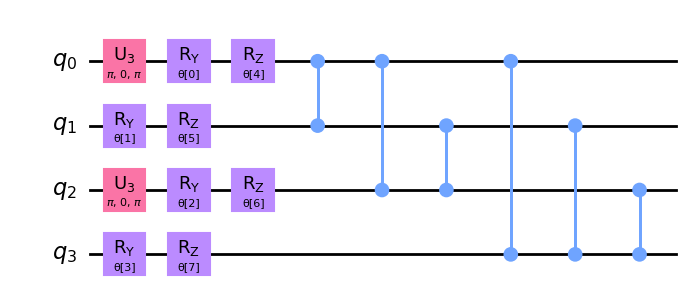

In [32]:
ansatz.decompose().draw('mpl')

In [25]:
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SPSA, SLSQP

optimizer_type = 'L_BFGS_B'

# You may want to tune the parameters 
# of each optimizer, here the defaults are used
if optimizer_type == 'COBYLA':
    optimizer = COBYLA(maxiter=500)
elif optimizer_type == 'L_BFGS_B':
    optimizer = L_BFGS_B(maxfun=500)
elif optimizer_type == 'SPSA':
    optimizer = SPSA(maxiter=500)
elif optimizer_type == 'SLSQP':
    optimizer = SLSQP(maxiter=500)

In [18]:
from qiskit import Aer
backend = Aer.get_backend('statevector_simulator')

In [26]:
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver
import numpy as np 

def exact_diagonalizer(problem, converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result

result_exact = exact_diagonalizer(problem, converter)
exact_energy = np.real(result_exact.eigenenergies[0])
print("Exact electronic energy", exact_energy)
print(result_exact)

Exact electronic energy -1.697007028852903
=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -84.700895930366
  - computed part:      -1.697007028853
  - ActiveSpaceTransformer extracted energy part: -83.003888901513
~ Nuclear repulsion energy (Hartree): 9.819476509782
> Total ground state energy (Hartree): -74.881419420584
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [2.86710004  0.0  0.0]
 
  0: 
  * Electronic dipole moment (a.u.): [2.0649676  0.0  0.0]
    - computed part:      [0.0022825  0.0  0.0]
    - ActiveSpaceTransformer extracted energy part: [2.0626851  0.0  0.0]
  > Dipole moment (a.u.): [0.80213244  0.0  0.0]  Total: 0.80213244
                 (debye): [2.0388171  0.0  0.0]  Total: 2.0388171
 


In [27]:
from qiskit.algorithms import VQE
from IPython.display import display, clear_output

# Print and save the data in lists
def callback(eval_count, parameters, mean, std):  
    # Overwrites the same line when printing
    display("Evaluation: {}, Energy: {}, Std: {}".format(eval_count, mean, std))
    clear_output(wait=True)
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)

counts = []
values = []
params = []
deviation = []

# Set initial parameters of the ansatz
# We choose a fixed small displacement 
# So all participants start from similar starting point
try:
    initial_point = [0.01] * len(ansatz.ordered_parameters)
except:
    initial_point = [0.01] * ansatz.num_parameters

algorithm = VQE(ansatz,
                optimizer=optimizer,
                quantum_instance=backend,
                callback=callback,
                initial_point=initial_point)

result = algorithm.compute_minimum_eigenvalue(qubit_op)

print(result)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 45,
    'eigenstate': array([-9.79660044e-15+1.95953160e-16j,  6.65553011e-08-6.65587170e-10j,
       -1.77190037e-21+1.77190169e-23j, -1.20365805e-14+4.35612004e-21j,
       -1.47209614e-07+1.47209193e-09j, -1.00000000e+00+3.25860861e-07j,
        2.66229786e-14+4.78891004e-21j, -1.80832732e-07-1.80829574e-09j,
       -3.40455024e-22+3.40449080e-24j, -2.31272275e-15+4.16009843e-22j,
        6.15715684e-29+2.00637644e-35j, -4.18215973e-22-4.18214777e-24j,
        5.11537047e-15+1.85128724e-21j, -3.47454141e-08-3.47454399e-10j,
        9.25026410e-22+9.25073887e-24j,  6.28247980e-15+1.25663160e-16j]),
    'eigenvalue': (-1.695761959971475+0j),
    'optimal_circuit': None,
    'optimal_parameters': {   ParameterVectorElement(θ[6]): 0.009999854017960072,
                              ParameterVectorElement(θ[5]): 0.009999817972044717,
                              ParameterVectorElement(θ[4]): 0.009999312232361637,
         

/tmp/ipykernel_11661/2841387939.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append([result_dict])


,optimizer,ansatz,rotation blocks,entanglement_blocks,entanglement,repetitions,# of qubits,# of parameters,# of CNOTs,# of evaluations,error (mHa)
0,L_BFGS_B,UCCSD,NaN,NaN,NaN,NaN,4,3,56,28,1.119105e-10
1,SPSA,UCCSD,NaN,NaN,NaN,NaN,4,3,56,1000,1.840375e-01
2,SPSA,PUCCD,NaN,NaN,NaN,NaN,4,1,48,1000,6.439294e-12
3,L_BFGS_B,UCCSD,NaN,NaN,NaN,NaN,4,3,56,28,1.167955e-10
4,L_BFGS_B,QuantumCircuit,NaN,NaN,NaN,NaN,4,1,3,2,4.241874e+02
5,L_BFGS_B,QuantumCircuit,NaN,NaN,NaN,NaN,4,1,3,2,4.241874e+02
0,L_BFGS_B,TwoLocal,"[ry, rz]",cz,full,1.0,4,8,6,45,1.245069e+00


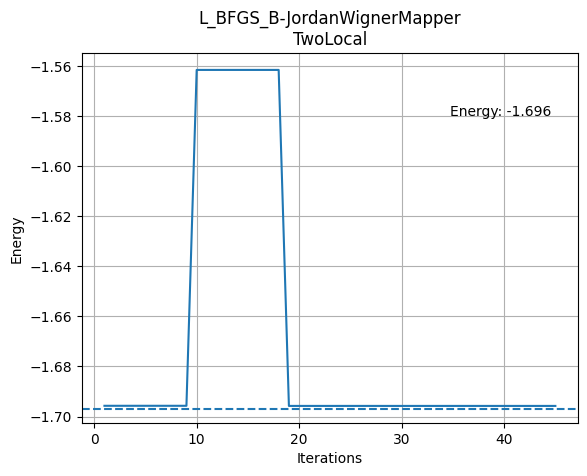

In [28]:
# Store results in a dictionary
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller

# Unroller transpile your circuit into CNOTs and U gates
pass_ = Unroller(['u', 'cx'])
pm = PassManager(pass_)
ansatz_tp = pm.run(ansatz)
cnots = ansatz_tp.count_ops()['cx']

energy = result.optimal_value

if ansatz_type == "TwoLocal":
    result_dict = {
        'optimizer': optimizer.__class__.__name__,
        'mapping': converter.mapper.__class__.__name__,
        'ansatz': ansatz.__class__.__name__,
        'rotation blocks': rotation_blocks,
        'entanglement_blocks': entanglement_blocks,
        'entanglement': entanglement,
        'repetitions': repetitions,
        'skip_final_rotation_layer': skip_final_rotation_layer,
        'energy (Ha)': energy,
        'error (mHa)': (energy-exact_energy)*1000,
        '# of parameters': len(result.optimal_point),
        'final parameters': result.optimal_point,
        '# of evaluations': result.cost_function_evals,
        '# of qubits': int(qubit_op.num_qubits),
        '# of CNOTs': cnots}
else:
    result_dict = {
        'optimizer': optimizer.__class__.__name__,
        'mapping': converter.mapper.__class__.__name__,
        'ansatz': ansatz.__class__.__name__,
        'rotation blocks': None,
        'entanglement_blocks': None,
        'entanglement': None,
        'repetitions': None,
        'skip_final_rotation_layer': None,
        'energy (Ha)': energy,
        'error (mHa)': (energy-exact_energy)*1000,
        '# of parameters': len(result.optimal_point),
        'final parameters': result.optimal_point,
        '# of evaluations': result.cost_function_evals,
        '# of qubits': int(qubit_op.num_qubits),
        '# of CNOTs': cnots}

# Plot the results
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('Iterations')
ax.set_ylabel('Energy')
ax.grid()
fig.text(0.7, 0.75, f'Energy: {result.optimal_value:.3f}')
plt.title(f"{result_dict['optimizer']}-{result_dict['mapping']}\n{result_dict['ansatz']}")
ax.plot(counts, values)
ax.axhline(exact_energy, linestyle='--')
fig_title = f"\
{result_dict['optimizer']}-\
{result_dict['mapping']}-\
{result_dict['ansatz']}-\
Energy({result_dict['energy (Ha)']:.3f}).png"
fig.savefig(fig_title, dpi=300)

# Display and save the data
import pandas as pd
import os.path
filename = 'results_h2o.csv'
if os.path.isfile(filename):
    result_df = pd.read_csv(filename)
    result_df = result_df.append([result_dict])
else:
    result_df = pd.DataFrame.from_dict([result_dict])
result_df.to_csv(filename)
result_df[['optimizer','ansatz', 'rotation blocks', 'entanglement_blocks',
    'entanglement', 'repetitions', '# of qubits', '# of parameters', '# of CNOTs', '# of evaluations', 'error (mHa)']]